# Data Wrangling

In [1]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
import os
import pandas as pd

dataset = "tarun.csv"

if os.path.isfile(dataset):
    df = pd.read_csv("tarun.csv")
else:
    url = r"http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz"
    df = pd.read_json(url, compression='gzip', lines=True)
display(df.head(10))

,Unnamed: 0,0,1,2
0,2698442,2,An Amalgam,This book is an amalgam of bits and pieces and...
1,2646715,5,Great!!!,"Well, not much to say. If you saw the first se..."
2,2119569,2,Hit&Miss,Babyface in his hey day always had a Cut that ...
3,816322,5,Great Buy,This text is considered The Bible for any poli...
4,1476562,3,What time is it anyway?,I thought the other reviews weren't serious ab...
5,17087,3,PRETTY FUNNY,"GOOD,BUT UNREALISTIC.THE GUY JUST QUIT GOING T..."
6,1838666,5,Lacy J. Dalton,I saw Lacy on Bill Anderson's Country Reunion ...
7,1442704,4,Great,Easy and enjoyable to watch. I would recommend...
8,1114640,3,Be careful!!!!,I am a very advanced exerciser and have used t...
9,1308335,5,the best book in the world!!!,Sahara special is one of the best books I have...


In [3]:
df = df.drop('Unnamed: 0',axis=1)

In [4]:
df.columns=['overall','title','reviewText']

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     750000 non-null  int64 
 1   title       749983 non-null  object
 2   reviewText  750000 non-null  object
dtypes: int64(1), object(2)
memory usage: 17.2+ MB
None


The unixReviewTime is converted from Unix time to the more intuitive datetime datatype.

In [6]:
print(df["reviewText"].iloc[0])

This book is an amalgam of bits and pieces and techniques and strategies from other books about creative thinking on the market. If the reader has read very little in the field, then this book might at least be a start.


Each review is associated with a rating stored under the overall field. This serves as the quantified summary of a given review and will thus be used as the ground truth labels for the model.

In [7]:
print(df.overall.unique())

[2 5 3 4 1]


# NLP Pre-Processing

In [8]:
sample_review = df["reviewText"].iloc[749999]
print(sample_review)

I have been searching and searching for a good litter box. I Have been through so many and have wasted so much money. When I got this, our smaller and younger cat was all for it. She used it immediately. Our bigger, older kitty was hesitant. I kept an eye on him and now he is using it! There is no mess and it's so much easier to clean! I highly recommend it!!!!


# HTML Entities

Some special characters like the apostrophe (’) and the en dash (–) are expressed as a set of numbers prefixed by &# and suffixed by ;. This is because the dataset was scraped from an HTML parser, and the dataset itself includes data that predated the universal UTF-8 standard.

These HTML Entities can be decoded by importing the html library.

In [9]:
import html

decoded_review = html.unescape(sample_review)
print(decoded_review)

I have been searching and searching for a good litter box. I Have been through so many and have wasted so much money. When I got this, our smaller and younger cat was all for it. She used it immediately. Our bigger, older kitty was hesitant. I kept an eye on him and now he is using it! There is no mess and it's so much easier to clean! I highly recommend it!!!!


Since punctuation marks do not add value in the way we'll perform NLP, all the HTML entities in the review texts can be dropped. The output series preprocessed is our reviewText but without the special characters.

In [10]:
pattern = r"\&\#[0-9]+\;"
df = df.sample(frac=0.03)
df["preprocessed"] = df["reviewText"].str.replace(pat=pattern, repl="", regex=True)

print(df["preprocessed"].iloc[1])

This is a good exhibition catalogue for the Lille showing of Ruben's work, but is not a comprehensive catalogue raisonne of his work. Since a number of his masterpieces could not be shipped to Lille, they are not included in the book - with the exception of some small black and white reproductions. It would have been great to have large colour plates of works such as the Samson and Delilah in the National Gallery in London.In spite of this limitation the book is definitely still worth having: the reproductions are excellent and the selection of works is representative.


In [11]:
df

,overall,title,reviewText,preprocessed
79303,1,Tiny and Junky Combo Lock Safe,I thought it would be fun for my son to have a...,I thought it would be fun for my son to have a...
26210,4,Not quite what I was looking for,This is a good exhibition catalogue for the Li...,This is a good exhibition catalogue for the Li...
575273,3,A Step Down,This album was the first of lackluster albums ...,This album was the first of lackluster albums ...
164257,4,Well done Tatyana!!!,"Although only a medioka album, I still love it...","Although only a medioka album, I still love it..."
15949,5,Great Concert Photos!!!,This is an absolutely delightful book for anyo...,This is an absolutely delightful book for anyo...
...,...,...,...,...
643602,4,Friday The 13 - The Series,This is a great cult classic from the 1980s. C...,This is a great cult classic from the 1980s. C...
429247,3,Great Gizmo,"I was a little weary on buying this product, b...","I was a little weary on buying this product, b..."
537682,4,1 out of 4 cats love them,I have 4 cats. One cat absolutely loves these ...,I have 4 cats. One cat absolutely loves these ...
457108,5,Simply the best,There is no doubt that this is the best book d...,There is no doubt that this is the best book d...


In [12]:
%%time
import re
import nltk

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet

#import nltk resources
#resources = ["wordnet", "stopwords", "punkt", \
 #            "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]
resources = ["wordnet", "stopwords"]
for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource)

#create Lemmatizer object
lemma = WordNetLemmatizer()

def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", " ", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

#apply our functions
df["preprocessed"] = df["preprocessed"].apply(lambda row: lemmatize_doc(row))

print(df["preprocessed"].iloc[1])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This be a good exhibition catalogue for the Lille showing of Ruben s work but be not a comprehensive catalogue raisonne of his work Since a number of his masterpiece could not be ship to Lille they be not include in the book - with the exception of some small black and white reproduction It would have be great to have large colour plate of work such as the Samson and Delilah in the National Gallery in London In spite of this limitation the book be definitely still worth have : the reproduction be excellent and the selection of work be representative
Wall time: 2min 58s


In [13]:
from unicodedata import normalize

remove_accent = lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")

df["preprocessed"] = df["preprocessed"].apply(remove_accent)

print(df["preprocessed"].iloc[1])

This be a good exhibition catalogue for the Lille showing of Ruben s work but be not a comprehensive catalogue raisonne of his work Since a number of his masterpiece could not be ship to Lille they be not include in the book - with the exception of some small black and white reproduction It would have be great to have large colour plate of work such as the Samson and Delilah in the National Gallery in London In spite of this limitation the book be definitely still worth have : the reproduction be excellent and the selection of work be representative


In [14]:
pattern = r"[^\w\s]"

df["preprocessed"] = df["preprocessed"].str.replace(pat=pattern, repl=" ", regex=True)

print(df["preprocessed"].iloc[1])

This be a good exhibition catalogue for the Lille showing of Ruben s work but be not a comprehensive catalogue raisonne of his work Since a number of his masterpiece could not be ship to Lille they be not include in the book   with the exception of some small black and white reproduction It would have be great to have large colour plate of work such as the Samson and Delilah in the National Gallery in London In spite of this limitation the book be definitely still worth have   the reproduction be excellent and the selection of work be representative


In [15]:
df["preprocessed"] = df["preprocessed"].str.lower()

print(df["preprocessed"].iloc[1])

this be a good exhibition catalogue for the lille showing of ruben s work but be not a comprehensive catalogue raisonne of his work since a number of his masterpiece could not be ship to lille they be not include in the book   with the exception of some small black and white reproduction it would have be great to have large colour plate of work such as the samson and delilah in the national gallery in london in spite of this limitation the book be definitely still worth have   the reproduction be excellent and the selection of work be representative


In [16]:
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

stop_words = [word.replace("\'", "") for word in stop_words]

print(f"sample stop words: {stop_words[:15]} \n")

remove_stop_words = lambda row: " ".join([token for token in row.split(" ") \
                                          if token not in stop_words])
df["preprocessed"] = df["preprocessed"].apply(remove_stop_words)

print(df["preprocessed"].iloc[1])

sample stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours'] 

good exhibition catalogue lille showing ruben work comprehensive catalogue raisonne work since number masterpiece could ship lille include book   exception small black white reproduction would great large colour plate work samson delilah national gallery london spite limitation book definitely still worth   reproduction excellent selection work representative


In [17]:
pattern = r"[\s]+"

df["preprocessed"] = df["preprocessed"].str.replace(pat=pattern, repl=" ", regex=True)

print(df["preprocessed"].iloc[1])

good exhibition catalogue lille showing ruben work comprehensive catalogue raisonne work since number masterpiece could ship lille include book exception small black white reproduction would great large colour plate work samson delilah national gallery london spite limitation book definitely still worth reproduction excellent selection work representative


In [18]:
corpora = df["preprocessed"].values
tokenized = [corpus.split(" ") for corpus in corpora]

print(tokenized[1])

['good', 'exhibition', 'catalogue', 'lille', 'showing', 'ruben', 'work', 'comprehensive', 'catalogue', 'raisonne', 'work', 'since', 'number', 'masterpiece', 'could', 'ship', 'lille', 'include', 'book', 'exception', 'small', 'black', 'white', 'reproduction', 'would', 'great', 'large', 'colour', 'plate', 'work', 'samson', 'delilah', 'national', 'gallery', 'london', 'spite', 'limitation', 'book', 'definitely', 'still', 'worth', 'reproduction', 'excellent', 'selection', 'work', 'representative']


In [19]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

bi_gram = Phrases(tokenized, min_count=300, threshold=50)

tri_gram = Phrases(bi_gram[tokenized], min_count=300, threshold=50)

In [20]:
tri_gram

In [21]:
uni_gram_tokens = set([token for text in tokenized for token in text])
uni_gram_tokens = set(filter(lambda x: x != "", uni_gram_tokens))

print(list(uni_gram_tokens)[:50])

['systema', 'hinton', 'isaak', 'notepad', 'callie', 'unplug', 'winterland', 'hans', 'waterman', 'dishonor', 'inorganic', 'likeable', 'muc', 'colorado', 'variance', 'merrill', 'channel', 'dialpad', 'pressing', 'unctuous', '26', 'genisis', 'drip', 'reavealing', 'armitage', 'vis', 'series', 'unnoticed', 'jugular', 'nordic', 'services', 'agey', 'paragrpahs', 'smolder', 'mccloskey', 'flexible', 'sakes', 'returnsbuy', 'ingedient', '1st', 'furiousness', 'require', 'incarnation', 'fact', '2013', 'unintegrated', 'beaubourg', 'bats', '_wherever_', 'starforce']


In [22]:
bigram_min = bi_gram.min_count

bi_condition = lambda x: x[1] >= bigram_min

bi_gram_tokens = dict(filter(bi_condition, bi_gram.vocab.items()))
bi_gram_tokens = set([token.decode("utf-8") \
                      for token in bi_gram_tokens])

bi_grams_only = bi_gram_tokens.difference(uni_gram_tokens)
print(list(bi_grams_only)[:50])

['', 'buy_book', 'waste_money', 'year_old', 'highly_recommend', 'would_recommend', 'work_well', 'read_book', 'year_ago']


In [23]:
trigram_min = tri_gram.min_count

tri_condition = lambda x: x[1] >= trigram_min

tri_gram_tokens = dict(filter(tri_condition, tri_gram.vocab.items()))
tri_gram_tokens = set([token.decode("utf-8") \
                       for token in tri_gram_tokens])

tri_grams_only = tri_gram_tokens.difference(bi_gram_tokens)
print(list(tri_grams_only)[:50])

[]


In [24]:
#tokenized = [Phraser(tri_gram)[Phraser(bi_gram)[i]] for i in tokenized]

In [25]:
tokenized = [list(filter(lambda x: len(x) > 1, document)) \
             for document in tokenized]

print(tokenized[1])

['good', 'exhibition', 'catalogue', 'lille', 'showing', 'ruben', 'work', 'comprehensive', 'catalogue', 'raisonne', 'work', 'since', 'number', 'masterpiece', 'could', 'ship', 'lille', 'include', 'book', 'exception', 'small', 'black', 'white', 'reproduction', 'would', 'great', 'large', 'colour', 'plate', 'work', 'samson', 'delilah', 'national', 'gallery', 'london', 'spite', 'limitation', 'book', 'definitely', 'still', 'worth', 'reproduction', 'excellent', 'selection', 'work', 'representative']


In [26]:
len(tokenized)

22500

In [27]:
from gensim.corpora.dictionary import Dictionary

vocabulary = Dictionary(tokenized)

vocabulary_keys = list(vocabulary.token2id)[0:10]

for key in vocabulary_keys:
    print(f"ID: {vocabulary.token2id[key]}, Token: {key}")

ID: 0, Token: 10
ID: 1, Token: 13
ID: 2, Token: already
ID: 3, Token: amazon
ID: 4, Token: angry
ID: 5, Token: arrive
ID: 6, Token: away
ID: 7, Token: bank
ID: 8, Token: box
ID: 9, Token: co


In [28]:
bow = [vocabulary.doc2bow(doc) for doc in tokenized]

for idx, freq in bow[0]:
    print(f"Word: {vocabulary.get(idx)}, Frequency: {freq}")

Word: 10, Frequency: 1
Word: 13, Frequency: 1
Word: already, Frequency: 1
Word: amazon, Frequency: 2
Word: angry, Frequency: 1
Word: arrive, Frequency: 1
Word: away, Frequency: 1
Word: bank, Frequency: 1
Word: box, Frequency: 1
Word: co, Frequency: 1
Word: company, Frequency: 1
Word: deceptively, Frequency: 1
Word: dial, Frequency: 1
Word: disappointing, Frequency: 1
Word: even, Frequency: 1
Word: find, Frequency: 1
Word: fun, Frequency: 1
Word: go, Frequency: 1
Word: husband, Frequency: 1
Word: junk, Frequency: 2
Word: keep, Frequency: 1
Word: large, Frequency: 1
Word: line, Frequency: 1
Word: make, Frequency: 1
Word: money, Frequency: 1
Word: old, Frequency: 1
Word: open, Frequency: 1
Word: oriental, Frequency: 2
Word: past, Frequency: 1
Word: pay, Frequency: 1
Word: real, Frequency: 1
Word: regret, Frequency: 1
Word: return, Frequency: 1
Word: safe, Frequency: 3
Word: saw, Frequency: 1
Word: sell, Frequency: 1
Word: seriously, Frequency: 1
Word: shopping, Frequency: 1
Word: sister, 

In [29]:
from gensim.models.tfidfmodel import TfidfModel

tfidf = TfidfModel(bow)

for idx, weight in tfidf[bow[0]]:
    print(f"Word: {vocabulary.get(idx)}, Weight: {weight:.3f}")

Word: 10, Weight: 0.087
Word: 13, Weight: 0.128
Word: already, Weight: 0.087
Word: amazon, Weight: 0.152
Word: angry, Weight: 0.145
Word: arrive, Weight: 0.102
Word: away, Weight: 0.079
Word: bank, Weight: 0.157
Word: box, Weight: 0.089
Word: co, Weight: 0.133
Word: company, Weight: 0.099
Word: deceptively, Weight: 0.198
Word: dial, Weight: 0.143
Word: disappointing, Weight: 0.109
Word: even, Weight: 0.052
Word: find, Weight: 0.048
Word: fun, Weight: 0.079
Word: go, Weight: 0.046
Word: husband, Weight: 0.103
Word: junk, Weight: 0.240
Word: keep, Weight: 0.064
Word: large, Weight: 0.091
Word: line, Weight: 0.083
Word: make, Weight: 0.040
Word: money, Weight: 0.066
Word: old, Weight: 0.061
Word: open, Weight: 0.089
Word: oriental, Weight: 0.387
Word: past, Weight: 0.096
Word: pay, Weight: 0.086
Word: real, Weight: 0.076
Word: regret, Weight: 0.131
Word: return, Weight: 0.079
Word: safe, Weight: 0.383
Word: saw, Weight: 0.093
Word: sell, Weight: 0.098
Word: seriously, Weight: 0.121
Word: 

In [30]:
%%time
import numpy as np

from gensim.models import word2vec

np.set_printoptions(suppress=True)

feature_size = 100
context_size = 20
min_word = 1

word_vec= word2vec.Word2Vec(tokenized, size=feature_size, \
                            window=context_size, min_count=min_word, \
                            iter=50, seed=42)

Wall time: 1min 12s


In [31]:
word_vec_unpack = [(word, idx.index) for word, idx in \
                   word_vec.wv.vocab.items()]

tokens, indexes = zip(*word_vec_unpack)

word_vec_df = pd.DataFrame(word_vec.wv.syn0[indexes, :], index=tokens)

display(word_vec_df)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
think,2.814193,-0.436747,0.765209,-1.968797,-0.934403,1.303374,-1.406116,-1.771001,-0.290625,-2.741947,...,-1.990846,2.666936,-0.573104,0.890537,-3.377541,-0.542394,-2.741206,0.746427,-2.911303,-1.179639
would,0.391406,-3.525280,-2.831712,2.739182,0.192811,0.249956,-0.400331,1.436780,-1.356419,-2.190475,...,1.555386,2.074845,-1.994392,0.377417,-2.300840,-0.732495,-2.933653,-0.182056,-0.857681,-1.238282
fun,0.022010,-1.131484,-3.045422,-3.432300,-0.029328,3.299913,-0.460498,-0.524257,5.713945,2.792928,...,-2.947926,0.148031,-1.077387,2.539192,1.803787,-3.256958,0.634572,1.056548,0.564288,-0.433651
son,-0.130851,0.658545,0.344941,-3.762131,1.147212,3.045655,2.179999,-2.818044,4.626403,0.901077,...,1.984087,3.316790,-2.472602,-1.118701,-1.097528,2.168194,2.421177,-2.989718,-0.959211,-3.088238
safe,-0.910209,-2.229708,-1.127326,-1.073409,0.670675,3.848006,-0.090666,-0.618126,0.120788,0.591891,...,0.871308,1.104595,2.122101,-0.885222,-2.771085,-0.990979,0.667195,2.461865,-2.744655,-0.186352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
forouzan,-0.034591,-0.114958,0.147872,0.084949,0.167466,0.020888,-0.096639,-0.050260,0.237320,0.195899,...,0.127394,-0.278667,0.208731,0.275464,-0.379996,0.217660,-0.269803,-0.140211,0.105990,0.401645
communications,-0.327053,-0.076725,0.368338,-0.168325,0.148116,0.105936,-0.006415,-0.296638,0.363897,0.546991,...,0.144946,-0.520751,0.558783,0.362233,-0.723764,0.468388,-0.678220,-0.348726,0.262177,0.619289
stallings,-0.159600,-0.070163,0.171740,-0.118219,0.066756,0.079167,-0.000722,-0.136853,0.215772,0.290897,...,0.096909,-0.261047,0.278396,0.181200,-0.405219,0.223101,-0.362148,-0.157086,0.128388,0.337053
compuetr,-0.179382,-0.025086,0.191969,-0.152044,0.045786,0.070305,0.010599,-0.153980,0.199076,0.297457,...,0.092897,-0.269075,0.313642,0.157155,-0.400456,0.208017,-0.381407,-0.161107,0.157591,0.296275


In [32]:
word_vec_df.count()

0     46457
1     46457
2     46457
3     46457
4     46457
      ...  
95    46457
96    46457
97    46457
98    46457
99    46457
Length: 100, dtype: int64

In [33]:
%%time
tokenized_array = np.array(tokenized)

model_array = np.array([word_vec_df.loc[doc].mean(axis=0) for doc in tokenized_array])

Wall time: 18.2 s


In [34]:
a=df["overall"].reset_index().drop('index',axis=1)

In [35]:
a

,overall
0,1
1,4
2,3
3,4
4,5
...,...
22495,4
22496,3
22497,4
22498,5


In [36]:
model_df = pd.DataFrame(model_array)
model_df["label"] = a

display(model_df.head())

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.679018,-0.637220,-0.517301,-0.814562,-0.461430,1.647077,-0.126534,0.326036,0.530289,0.030550,...,0.700760,1.106987,-0.280234,-0.858432,-0.169990,0.016147,-1.197886,-0.490228,-0.700027,1
1,0.869092,0.304794,-0.345444,0.694746,-0.278811,-0.090160,0.028226,0.430262,-0.496396,-0.425425,...,0.204356,0.227867,-0.181259,-0.579492,-0.368161,-0.874337,-0.570287,0.805385,0.900037,4
2,-0.306551,0.412774,1.524191,-0.101377,-0.311287,-0.407061,-0.193626,0.361703,-0.685738,0.917743,...,-0.098828,0.742361,0.488472,-0.774164,0.859785,-0.366617,-0.010775,1.094483,-2.015304,3
3,-0.804866,-0.138679,-0.616397,0.063160,0.493095,0.842036,-0.196404,0.837598,-0.829030,0.155208,...,0.869151,-0.053495,0.559533,-0.967066,-0.229704,-0.982381,-0.714892,0.808650,-1.378300,4
4,0.294535,1.168397,1.519857,-0.094605,0.448545,0.412297,-0.451552,-0.082914,-0.643887,-0.366782,...,-0.022600,-0.918053,0.820669,0.192677,-0.690733,-0.262196,-0.029250,0.703754,0.448359,5


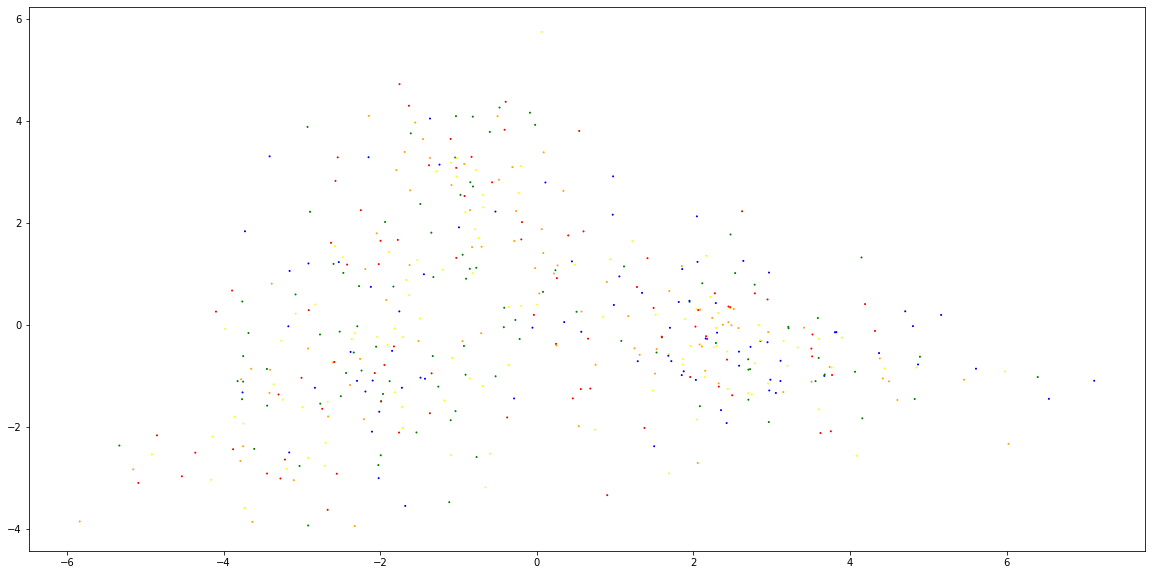

In [37]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

#sampling the model_df population
pca_df = model_df.reset_index()
pca_df = model_df.dropna(axis=0).iloc[:,1:]
pca_df = pca_df.iloc[::50]

#setting up PCA
pca = PCA(n_components=2, random_state=42)
pca = pca.fit_transform(pca_df.iloc[:, :-1])
labels = pca_df["label"]

#setting up plot components
x_axis = pca[:,0]
y_axis = pca[:,1]
color_map = pca_df["label"].map({1:"blue", \
                                 2:"red", \
                                 3:"yellow", \
                                 4:"green", \
                                 5:"orange"})

#plotting PCA
f, axes = plt.subplots(figsize=(20,10))
plt.scatter(x_axis, y_axis, color=color_map, s=1)
plt.show()

In [38]:
word_bank = ["nook", "phone", "tv", "good", "price"]

for word in word_bank[:]:
    related_vec = word_vec.wv.most_similar(word, topn=5)
    related_words = np.array(related_vec)[:,0]
    word_bank.extend(related_words)
    print(f"{word}: {related_words}")

nook: ['cranny' 'pulpy' 'silicone' 'skillet' 'shaft']
phone: ['cordless' 'handset' 'caller' 'speakerphone' 'gh']
tv: ['samsung' 'hdtv' 'satisifed' 'television' 'crt']
good: ['great' 'decent' 'nice' 'welter' 'iif']
price: ['39' 'midrange' 'resale' 'maniacs' '99']


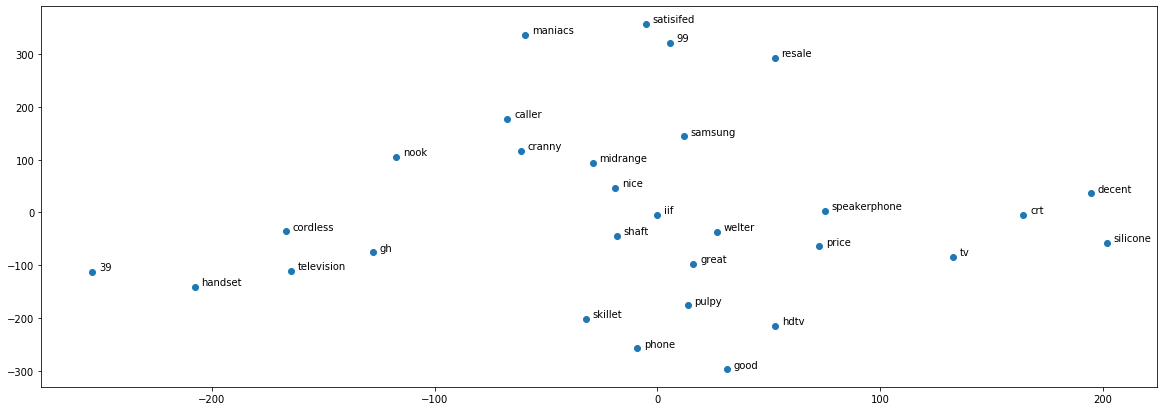

In [39]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42)

sample_vecs = word_vec.wv[set(word_bank)]
sample_tsne = tsne.fit_transform(sample_vecs)
tsne_x = sample_tsne[:, 0]
tsne_y = sample_tsne[:, 1]

f, axes = plt.subplots(figsize=(20,7))
ax = plt.scatter(x=tsne_x, y=tsne_y)

for label, x, y in zip(word_bank, tsne_x, tsne_y):
    plt.annotate(label, xy=(x+3, y+3))

plt.show()

In [40]:
word_vec.wv.most_similar(positive=["books", "away"], \
                      negative=[], topn=1)

[('touchin', 0.43718355894088745)]

In [41]:
word_vec.wv.most_similar(positive=["cheap"], \
                      negative=["quality"], topn=1)

[('scrub', 0.36304861307144165)]

In [42]:
word_vec.wv.most_similar(positive=["tablet"], \
                      negative=["phone"], topn=1)

[('chewable', 0.4448986053466797)]

In [43]:
df["reviewText"].iloc[1000]

'Highly recommend this brush. It has changed our lives! We only have to vacuum about once every 4 days instead of twice a day now! If you have any kind of dog/cat that has an undercoat or sheds I definitely recommend this product.'

In [44]:
#helpful = df["helpful"].tolist()
#most_helpful = max(helpful, key=lambda x: x[0])

#most_helpful_idx = df["helpful"].astype(str) == str(most_helpful)
#most_helpful_idx = df[most_helpful_idx].index

most_helpful_text = df["reviewText"].iloc[1000]

print(most_helpful_text)

Highly recommend this brush. It has changed our lives! We only have to vacuum about once every 4 days instead of twice a day now! If you have any kind of dog/cat that has an undercoat or sheds I definitely recommend this product.


In [45]:
%%time
import spacy

from collections import defaultdict

ner = spacy.load('en_core_web_sm')

ner_helpful = ner(most_helpful_text)

ner_dict = defaultdict(list)
for entity in ner_helpful.ents:
    ner_dict[entity.label_].append(entity)

for NER, name in ner_dict.items():
    print(f"{NER}:\n{name}\n")

DATE:
[every 4 days]

Wall time: 1.57 s


In [46]:
from spacy import displacy

displacy.render(ner_helpful, style="ent", jupyter=True)

In [47]:
def ner_displacy(sentence):
    ner_sentence = ner(sentence)
    displacy.render(ner_sentence, jupyter=True, \
                    options={"compact": False, \
                             "distance": 90, \
                             "word_spacing":20, \
                             "arrow_spacing":10, \
                             "arrow_stroke": 2, \
                             "arrow_width": 5})

for sentence in most_helpful_text.split(".")[0:3]:
    ner_displacy(sentence)

In [48]:
%%time
import multiprocessing

from gensim.models.ldamulticore import LdaMulticore

cores = multiprocessing.cpu_count()

num_topics = 10
bow_lda = LdaMulticore(bow, num_topics=num_topics, id2word=vocabulary, \
                       passes=5, workers=cores, random_state=42)

for token, frequency in bow_lda.show_topic(0, topn=5):
    print(token, frequency)

book 0.015190123
get 0.010918837
would 0.008176913
buy 0.0069915485
one 0.005943393
Wall time: 34.4 s


In [49]:
for topic in range(0, num_topics):
    print(f"\nTopic {topic+1}:")
    for token, frequency in bow_lda.show_topic(topic, topn=5):
        print(f" {token}, {frequency}")


Topic 1:
 book, 0.0151901226490736
 get, 0.010918837040662766
 would, 0.008176912553608418
 buy, 0.006991548463702202
 one, 0.0059433928690850735

Topic 2:
 book, 0.054381098598241806
 read, 0.019958948716521263
 one, 0.010449949651956558
 good, 0.007852267473936081
 get, 0.007177955936640501

Topic 3:
 one, 0.009740331210196018
 get, 0.009383311495184898
 like, 0.008617853745818138
 really, 0.007371833082288504
 would, 0.007212701253592968

Topic 4:
 cd, 0.014778190292418003
 song, 0.014752546325325966
 get, 0.011994078755378723
 one, 0.011423569172620773
 album, 0.011137542314827442

Topic 5:
 book, 0.017863167449831963
 would, 0.008539903908967972
 good, 0.008483591489493847
 like, 0.006755948532372713
 read, 0.006232354789972305

Topic 6:
 one, 0.014347769320011139
 get, 0.006575155537575483
 great, 0.0051882266998291016
 book, 0.005140886176377535
 dog, 0.005061458796262741

Topic 7:
 use, 0.013704575598239899
 product, 0.012750804424285889
 buy, 0.011428065598011017
 work, 0.011

In [50]:
import pyLDAvis.gensim

lda_idm = pyLDAvis.gensim.prepare(bow_lda, bow, vocabulary)

pyLDAvis.display(lda_idm)

In [51]:
nan_list = model_df[model_df[0].isna()].index
nan_list = nan_list.tolist()

print(nan_list[0:50])

[]


In [52]:
print(*[tokenized[blank] for blank in nan_list[0:5]])

In [53]:
for blank in nan_list[0:5]:
    display(df["reviewText"].iloc[blank])

In [54]:
print(f"Original 'model_df' count: {len(model_df)}")
print(f"Final 'model_df' count: {len(model_df.dropna(axis=0))}")

model_df = model_df.dropna(axis=0)
display(model_df.head())

Original 'model_df' count: 22500
Final 'model_df' count: 22500


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.679018,-0.637220,-0.517301,-0.814562,-0.461430,1.647077,-0.126534,0.326036,0.530289,0.030550,...,0.700760,1.106987,-0.280234,-0.858432,-0.169990,0.016147,-1.197886,-0.490228,-0.700027,1
1,0.869092,0.304794,-0.345444,0.694746,-0.278811,-0.090160,0.028226,0.430262,-0.496396,-0.425425,...,0.204356,0.227867,-0.181259,-0.579492,-0.368161,-0.874337,-0.570287,0.805385,0.900037,4
2,-0.306551,0.412774,1.524191,-0.101377,-0.311287,-0.407061,-0.193626,0.361703,-0.685738,0.917743,...,-0.098828,0.742361,0.488472,-0.774164,0.859785,-0.366617,-0.010775,1.094483,-2.015304,3
3,-0.804866,-0.138679,-0.616397,0.063160,0.493095,0.842036,-0.196404,0.837598,-0.829030,0.155208,...,0.869151,-0.053495,0.559533,-0.967066,-0.229704,-0.982381,-0.714892,0.808650,-1.378300,4
4,0.294535,1.168397,1.519857,-0.094605,0.448545,0.412297,-0.451552,-0.082914,-0.643887,-0.366782,...,-0.022600,-0.918053,0.820669,0.192677,-0.690733,-0.262196,-0.029250,0.703754,0.448359,5


In [55]:
model_df.label.value_counts()

1    4600
5    4550
4    4490
2    4481
3    4379
Name: label, dtype: int64

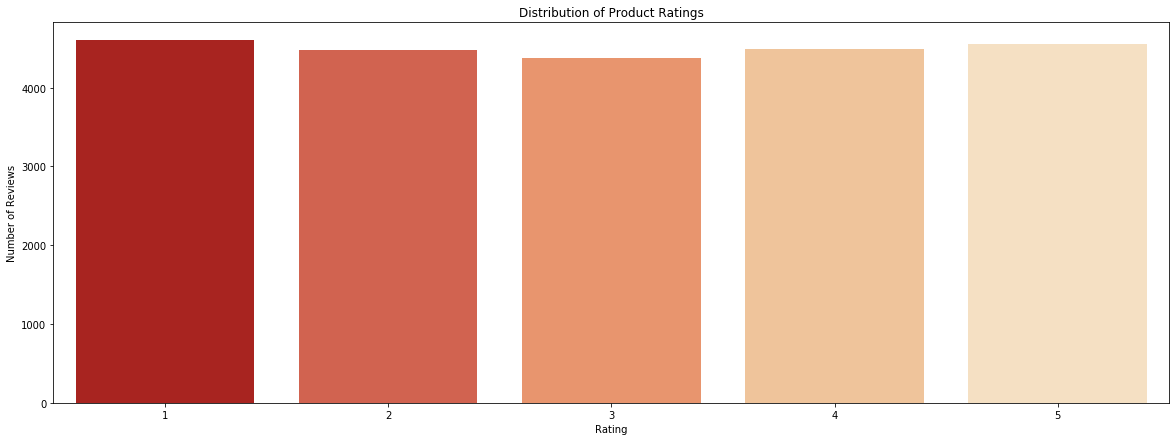

In [56]:
import seaborn as sns

f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=df["overall"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()

In [57]:
majority = df["overall"] == 5
majority_ratio = len(df[majority]) / len(df)

print(f"{majority_ratio*100:.2f}%")

20.22%


In [58]:
count = len(model_df[model_df["label"] == 2])
print(f"Size of the most underrepresented class: {count}")

Size of the most underrepresented class: 4481


In [59]:
 model_df["label"]

0        1
1        4
2        3
3        4
4        5
        ..
22495    4
22496    3
22497    4
22498    5
22499    4
Name: label, Length: 22500, dtype: int64

In [60]:
condition = model_df["label"] == 5

In [61]:
#trim the majority class
condition = model_df["label"] == 5.0
trimmed_df = model_df[condition].sample(n=count, random_state=42,replace=True)

#trim other class and add on to the trimmed_df
for rating in [1, 2, 3, 4]:
    condition = model_df["label"] == rating
    if len(model_df[condition]) >= count:
        add_df = model_df[condition].sample(n=count, random_state=42)
    else:
        add_df = model_df[condition]
    trimmed_df = pd.concat([trimmed_df, add_df], ignore_index=False)

#display new class sizes of trimmed_df
for rating in [1, 2, 3, 4, 5]:
    class_size = len(trimmed_df[trimmed_df["label"] == rating])
    print(f"Size of Class {rating}: {class_size}")

Size of Class 1: 4481
Size of Class 2: 4481
Size of Class 3: 4379
Size of Class 4: 4481
Size of Class 5: 4481


In [62]:
trimmed_df = trimmed_df.sort_values(by="label")
display(trimmed_df.tail())

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
12350,0.242104,-0.282711,-0.964034,-0.904637,-0.696863,-0.973463,0.302065,0.012578,0.562979,0.932335,...,0.250790,0.091654,0.233701,-0.819728,0.006645,0.560966,-0.393567,0.339822,-0.325041,5
10740,-1.355982,0.351989,0.084161,-0.346058,0.330699,0.592716,0.294943,-0.705763,-0.194145,0.003894,...,-0.002534,0.329878,-0.473987,0.600147,0.409340,-0.092710,0.621712,0.880672,-0.766810,5
18076,1.475502,0.538312,0.367923,-1.452135,2.889437,0.968104,-0.416660,0.363177,0.581416,0.987971,...,0.350430,-2.432035,0.573120,-0.971757,1.201843,0.785577,0.576743,0.963974,0.472636,5
20902,-0.074864,-1.054480,-0.255512,-2.129021,0.523319,-0.101454,1.545845,0.129598,0.643143,-0.048071,...,1.459717,-0.002790,-1.039606,-1.012342,-0.709306,-0.188550,1.075915,0.009388,-1.443693,5
4373,1.112873,-0.759333,-0.155554,-1.534890,-0.719172,0.828811,-1.118719,-0.124519,1.013624,1.683486,...,0.508798,0.034694,0.435879,-1.283120,-1.197301,0.186859,-1.572868,-0.613144,0.138215,5


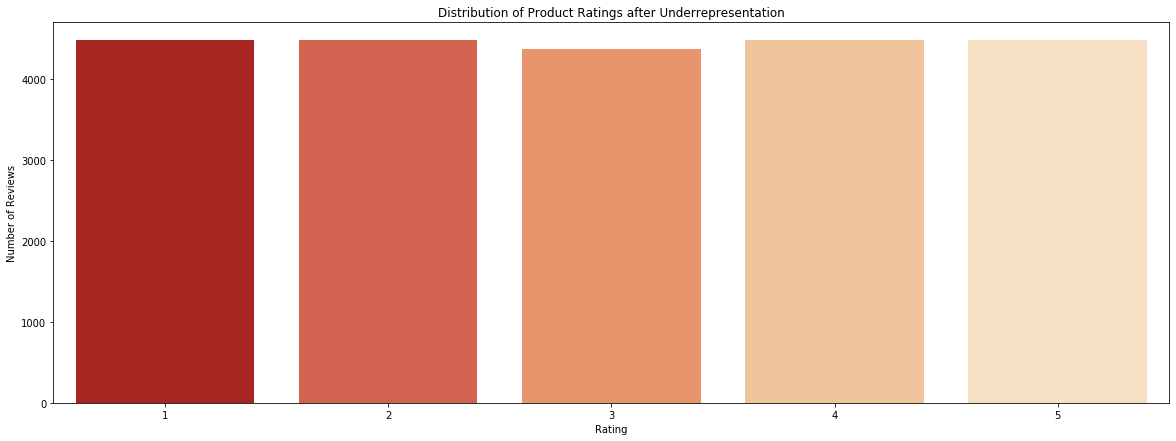

In [63]:
f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=trimmed_df["label"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings after Underrepresentation", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()

In [64]:
from sklearn.model_selection import train_test_split

X = trimmed_df.iloc[:, :-1]
y = trimmed_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)

In [65]:
from sklearn import metrics

label_shape = np.shape(y_test)
y_baseline = np.full(label_shape, 5)

accuracy_baseline = metrics.accuracy_score(y_test, y_baseline)
f1_score_baseline = metrics.f1_score(y_test, y_baseline, average="micro")

print(f"Baseline Accuracy: {accuracy_baseline*100:.3f}%")
print(f"Baseline F1 Score: {f1_score_baseline:.3f}")

Baseline Accuracy: 20.095%
Baseline F1 Score: 0.201


In [83]:
from sklearn.model_selection import train_test_split

X = model_df.iloc[:, :-1]
y = model_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.45, random_state=42)

In [88]:
%%time
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=10, class_weight={1:10, 2:12, 3:7, 4:9, 5:1}, \
                                criterion="entropy", random_state=42)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_pred)
f1_score = metrics.f1_score(y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")


Training Set Accuracy: 98.974%
Wall time: 2.97 s


# Logistic Regression

In [89]:
from sklearn.linear_model import LogisticRegression

clr = LogisticRegression()
clr.fit(X_train, y_train.values.ravel())
scores = clr.score(X_train, y_train) # accuracy
print("Logistic Regression : " , scores)

Logistic Regression :  0.4579393939393939


# XGBoost

In [145]:
#import XGBoost classifier and accuracy

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score



#instantiate model and train

model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)

model.fit(X_train, y_train)



# make predictions for test set

y_pred = model.predict(X_test)

predictions = [round(value) for value in y_pred]



accuracy = accuracy_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 41.16%


      0         1
0   2.0  0.659839
1   2.0  0.630031
2   2.0  0.622359
3   1.0  0.614293
4   1.0  0.607913
5   1.0  0.606685
6   2.0  0.604507
7   2.0  0.600887
8   2.0  0.592432
9   1.0  0.592374
10  3.0  0.590305
11  2.0  0.589917
12  2.0  0.588308
13  2.0  0.586158
14  2.0  0.585081
15  2.0  0.574797
16  2.0  0.574529
17  1.0  0.573737
18  3.0  0.571724
19  3.0  0.569910
0.5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars


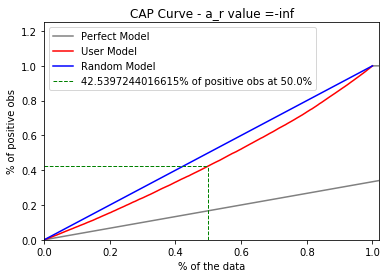

In [148]:
y_pred_proba = model.predict_proba(X_test)
capcurve(y_values=y_test, y_preds_proba=y_pred_proba[:,1])

In [149]:
import matplotlib.pyplot as plt
from scipy import integrate
def capcurve(y_values, y_preds_proba):

    num_pos_obs = np.sum(y_values)

    num_count = len(y_values)

    rate_pos_obs = float(num_pos_obs) / float(num_count)

    ideal = pd.DataFrame({'x':[0,rate_pos_obs,1],'y':[0,1,1]})

    xx = np.arange(num_count) / float(num_count - 1)

    y_cap = np.c_[y_values,y_preds_proba]

    y_cap_df_s = pd.DataFrame(data=y_cap)

    y_cap_df_s = y_cap_df_s.sort_values([1], ascending=False).reset_index(level = y_cap_df_s.index.names, drop=True)

    

    print(y_cap_df_s.head(20))

    

    yy = np.cumsum(y_cap_df_s[0]) / float(num_pos_obs)
    yy = np.append([0], yy[0:num_count-1]) #add the first curve point (0,0) : for xx=0 we have yy=0
    percent = 0.5
    #row_index = np.trunc(num_count * percent)
    row_index = int(np.trunc(num_count * percent))
    val_y1 = yy[row_index]
    val_y2 = yy[row_index+1]
    if val_y1 == val_y2:
        val = val_y1*1.0
    else:
        val_x1 = xx[row_index]
        val_x2 = xx[row_index+1]
    val = val_y1 + ((val_x2 - percent)/(val_x2 - val_x1))*(val_y2 - val_y1) 
    sigma_ideal = 1 * xx[len(xx) - 1 ] / 2 + (xx[num_count - 1] - xx[len(xx)-1]) * 1
   # sigma_ideal=5.95
    sigma_model = integrate.simps(yy,xx)
    sigma_random = integrate.simps(xx,xx)
    print(sigma_random)
    ar_value = (sigma_model - sigma_random) / (sigma_ideal - sigma_random)
    #ar_label = 'ar value = %s' % ar_value
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    ax.plot(ideal['x'],ideal['y'], color='grey', label='Perfect Model')
    ax.plot(xx,yy, color='red', label='User Model')
    #ax.scatter(xx,yy, color='red')
    ax.plot(xx,xx, color='blue', label='Random Model')
    ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    ax.plot([0, percent], [val, val], color='green', linestyle='--', linewidth=1, label=str(val*100)+'% of positive obs at '+str(percent*100)+'%')
    plt.xlim(0, 1.02)
    plt.ylim(0, 1.25)
    plt.title("CAP Curve - a_r value ="+str(ar_value))
    plt.xlabel('% of the data')
    plt.ylabel('% of positive obs')
    plt.legend()
    plt.show()

      0    1
0   1.0  0.8
1   1.0  0.7
2   1.0  0.7
3   2.0  0.7
4   2.0  0.7
5   3.0  0.7
6   2.0  0.7
7   4.0  0.7
8   3.0  0.7
9   2.0  0.7
10  1.0  0.7
11  3.0  0.7
12  2.0  0.7
13  2.0  0.7
14  5.0  0.6
15  4.0  0.6
16  4.0  0.6
17  1.0  0.6
18  1.0  0.6
19  2.0  0.6
0.5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars


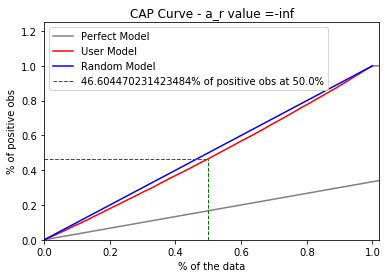

In [150]:
y_pred_proba = forest.predict_proba(X=X_test)
capcurve(y_values=y_test, y_preds_proba=y_pred_proba[:,1])

      0         1
0   2.0  0.718508
1   3.0  0.683245
2   1.0  0.673024
3   2.0  0.646847
4   2.0  0.634726
5   3.0  0.633618
6   2.0  0.625540
7   2.0  0.624131
8   2.0  0.604425
9   2.0  0.603924
10  2.0  0.599810
11  2.0  0.597493
12  3.0  0.597413
13  2.0  0.594172
14  2.0  0.592999
15  1.0  0.591078
16  1.0  0.590498
17  2.0  0.587244
18  1.0  0.585288
19  2.0  0.584875
0.5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars


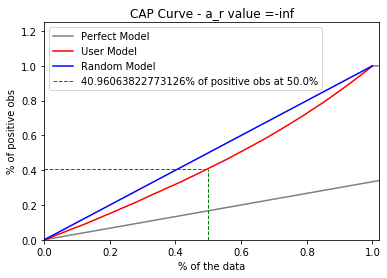

In [151]:
y_pred_proba = clr.predict_proba(X=X_test)
capcurve(y_values=y_test, y_preds_proba=y_pred_proba[:,1])

# SVM

In [152]:
X_train.shape
y_train.shape

(12375,)

In [153]:
from sklearn import svm
# instantiate and train model, kernel=rbf 
svm_rbf = svm.SVC(random_state=12345,probability=True)
svm_rbf.fit(X_train, y_train)

# evaulate model
y_pred_1 = svm_rbf.predict(X_train)
print(" SVM : ", y_pred_1)


def eval_predictions(y_test, y_pred):
    print ('accuracy:', metrics.accuracy_score(y_test, y_pred))
    print ('precision:', metrics.precision_score(y_test, y_pred, average='weighted'))
    print ('recall:', metrics.recall_score(y_test, y_pred, average='weighted'))
    print ('F-measure:', metrics.f1_score(y_test, y_pred, average='weighted'))
eval_predictions(y_train, y_pred_1)


 SVM :  [4 1 4 ... 2 3 2]
accuracy: 0.664969696969697
precision: 0.66318446631683
recall: 0.664969696969697
F-measure: 0.6627176020079383


      0         1
0   2.0  0.654791
1   1.0  0.650699
2   2.0  0.635319
3   1.0  0.628823
4   2.0  0.628140
5   2.0  0.622424
6   4.0  0.613986
7   1.0  0.608578
8   2.0  0.607533
9   5.0  0.604450
10  1.0  0.601489
11  2.0  0.597636
12  3.0  0.594757
13  3.0  0.591945
14  2.0  0.590507
15  3.0  0.582579
16  1.0  0.578666
17  3.0  0.576405
18  2.0  0.576242
19  2.0  0.573454
0.5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars


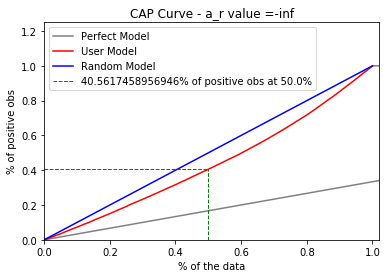

In [154]:
y_pred_proba = svm_rbf.predict_proba(X=X_test)
capcurve(y_values=y_test, y_preds_proba=y_pred_proba[:,1])

# GBoost model with learning curves

In [155]:
## How to evaluate XGBoost model with learning curves
## DataSet: skleran.datasets.load_breast_cancer()

    
import warnings
warnings.filterwarnings("ignore")

# load libraries
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# load the datasets
   

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(XGBClassifier(),
                                               X, y, cv=2, scoring='accuracy', n_jobs=-1,
                                               # 50 different sizes of the training set
                                               train_sizes=np.linspace(0.01, 1.0, 5))

In [156]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

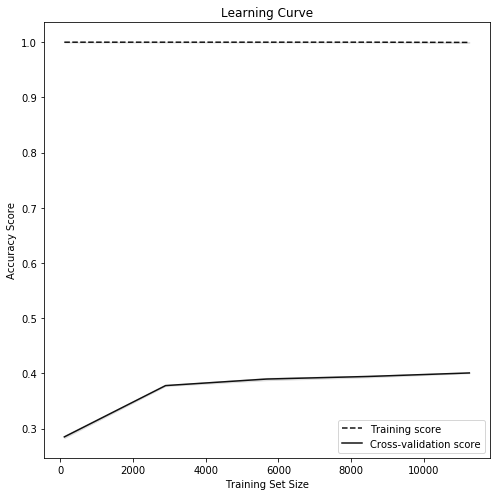

In [157]:
    # Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

    # Draw lines
plt.subplots(1, figsize=(7,7))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    # Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    # Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout(); plt.show()

# Linear Regression model with learning curves

In [158]:
from sklearn.linear_model import LinearRegression

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, validation_scores = learning_curve(LinearRegression(),
                                               X, y, cv=5, scoring='neg_mean_squared_error')
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

#learning_curves(RandomForestRegressor(max_leaf_nodes = 350), df, features, target, train_sizes, 5)

Training scores:

 [[-1.20916158 -1.14945635 -1.14945635 -1.14945635 -1.14945635]
 [-1.21804497 -1.21045994 -1.21587309 -1.21587309 -1.21587309]
 [-1.23454313 -1.22923009 -1.2112421  -1.2213359  -1.2213359 ]
 [-1.2479774  -1.24439657 -1.23114689 -1.23882423 -1.23140295]
 [-1.2450875  -1.24224883 -1.23187573 -1.23832378 -1.23957106]]

 ----------------------------------------------------------------------

Validation scores:

 [[-1.30111855 -1.32530157 -1.37395215 -1.34217509 -1.34725863]
 [-1.24914123 -1.25691015 -1.29627632 -1.26733087 -1.26560551]
 [-1.23756895 -1.24880095 -1.28744842 -1.26255568 -1.26031592]
 [-1.23340329 -1.24395297 -1.28504361 -1.2616067  -1.25965729]
 [-1.23178513 -1.24284009 -1.28457222 -1.25847809 -1.25622391]]


In [159]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1800     1.161397
5850     1.215225
9900     1.223537
13950    1.238750
18000    1.239421
dtype: float64

 --------------------

Mean validation scores

 1800     1.337961
5850     1.267053
9900     1.259338
13950    1.256733
18000    1.254780
dtype: float64


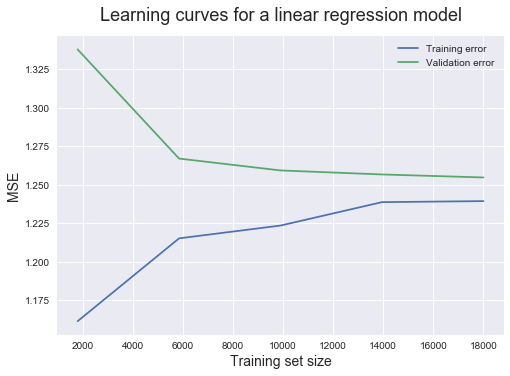

In [160]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()


# SVM Learning Curve

In [161]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)

In [162]:
from sklearn.svm import SVC

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, validation_scores = learning_curve(SVC(),
                                               X, y, cv=cv)
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[0.75111111 0.77555556 0.75888889]
 [0.70376068 0.70017094 0.69094017]
 [0.67353535 0.67636364 0.6710101 ]
 [0.66       0.66351254 0.65605735]
 [0.65144444 0.65205556 0.64872222]]

 ----------------------------------------------------------------------

Validation scores:

 [[0.398      0.39911111 0.41288889]
 [0.43155556 0.41644444 0.43133333]
 [0.43933333 0.42933333 0.44022222]
 [0.44377778 0.42333333 0.44111111]
 [0.446      0.43155556 0.44888889]]


In [163]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1800    -0.761852
5850    -0.698291
9900    -0.673636
13950   -0.659857
18000   -0.650741
dtype: float64

 --------------------

Mean validation scores

 1800    -0.403333
5850    -0.426444
9900    -0.436296
13950   -0.436074
18000   -0.442148
dtype: float64


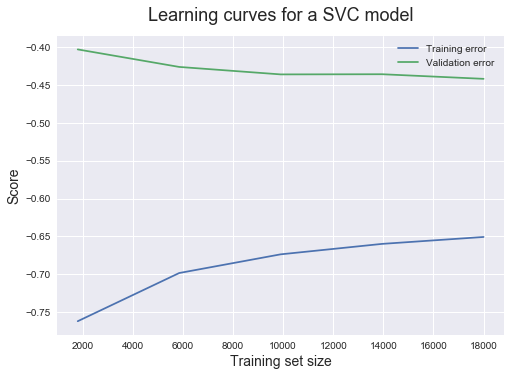

In [164]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a SVC model', fontsize = 18, y = 1.03)
plt.legend()

# Naive Bayes Learning Curve

In [165]:
from sklearn.naive_bayes import GaussianNB
# Create CV training and test scores for various training set sizes
#cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
train_sizes, train_scores, validation_scores = learning_curve(GaussianNB(),
                                               X, y, cv=cv)
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[0.41388889 0.43222222 0.45      ]
 [0.39452991 0.40068376 0.39230769]
 [0.38858586 0.3869697  0.38777778]
 [0.38551971 0.3902509  0.38623656]
 [0.38777778 0.38833333 0.38372222]]

 ----------------------------------------------------------------------

Validation scores:

 [[0.34955556 0.32888889 0.37088889]
 [0.36511111 0.34866667 0.36955556]
 [0.36711111 0.35444444 0.37222222]
 [0.36688889 0.35977778 0.37111111]
 [0.36555556 0.35977778 0.37044444]]


In [166]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1800    -0.432037
5850    -0.395840
9900    -0.387778
13950   -0.387336
18000   -0.386611
dtype: float64

 --------------------

Mean validation scores

 1800    -0.349778
5850    -0.361111
9900    -0.364593
13950   -0.365926
18000   -0.365259
dtype: float64


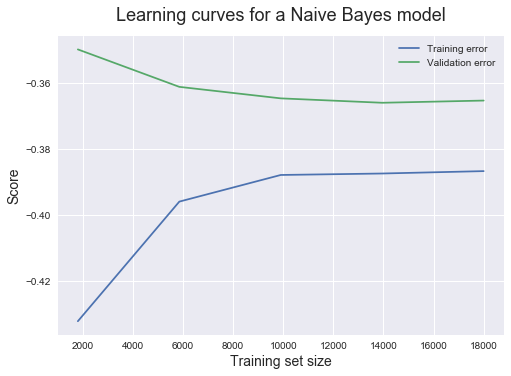

In [167]:
## plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
#plt.xlim(-100000, 110000)
#plt.ylim(-100000, 100000);
plt.title('Learning curves for a Naive Bayes model', fontsize = 18, y = 1.03)
plt.legend()



# Train Error vs Test Error

In [168]:
from sklearn import linear_model
# #############################################################################
# Compute train and test errors
alphas = np.logspace(-5, 1, 60)
enet = linear_model.ElasticNet(l1_ratio=0.7, max_iter=10000)
train_errors = list()
test_errors = list()
for alpha in alphas:
    enet.set_params(alpha=alpha)
    enet.fit(X_train, y_train)
    train_errors.append(enet.score(X_train, y_train))
    test_errors.append(enet.score(X_test, y_test))

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print("Optimal regularization parameter : %s" % alpha_optim)

Optimal regularization parameter : 1e-05


In [169]:
# Estimate the coef_ on full data with optimal regularization parameter
enet.set_params(alpha=alpha_optim)
coef_ = enet.fit(X, y).coef_

Text(0, 0.5, 'Performance')

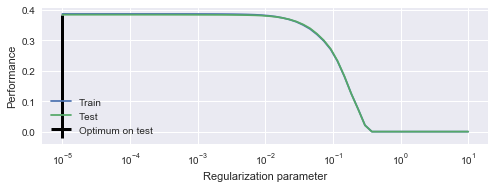

In [170]:
# #############################################################################
# Plot results functions

import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')

plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

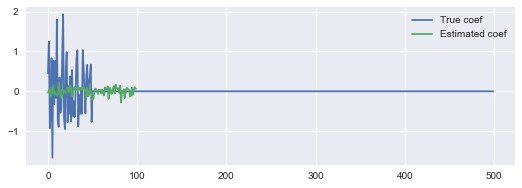

In [171]:
# Show estimated coef_ vs true coef
n_features = 500
coef = np.random.randn(n_features)
coef[50:] = 0.0  # only the top 10 features are impacting the model
plt.subplot(2, 1, 2)
plt.plot(coef, label='True coef')
plt.plot(coef_, label='Estimated coef')
plt.legend()
plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.26)
plt.show()

# Cross Validation Classification Accuracy

In [172]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
array = df.values
array.size
X = model_df.iloc[:, :-1]
y = model_df.iloc[:, -1]
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
#print("Accuracy: %.3f (%.3f) - ") % (results.mean(), results.std())  
print("Accuracy : results.mean()", results.mean())
print("Accuracy : results.std()", results.std())
      

Accuracy : results.mean() 0.43410147276424416
Accuracy : results.std() 0.011318593652668183


In [173]:
from sklearn.neighbors import KNeighborsClassifier
# check classification accuracy of KNN with K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
results = metrics.accuracy_score(y_test, y_pred)
print("Accuracy : results.mean()", results.mean())
print("Accuracy : results.std()", results.std())

Accuracy : results.mean() 0.31733333333333336
Accuracy : results.std() 0.0


# Log Loss

In [174]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = LogisticRegression()
scoring = 'neg_log_loss'
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("Accuracy : results.mean()", results.mean())
print("Accuracy : results.std()", results.std())

Accuracy : results.mean() -1.313671551718428
Accuracy : results.std() 0.014087349761044069


# Confusion Matrix

In [175]:
from sklearn.metrics import confusion_matrix
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_train, y_train, test_size=test_size, random_state=seed)
model = LogisticRegression()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
matrix = confusion_matrix(Y_test, predicted)
print(matrix)


[[514 165  74  31  57]
 [256 255 171  98  67]
 [107 190 225 156  87]
 [ 63  79 184 264 236]
 [ 53  48  64 160 480]]


# Classification Report

In [176]:
from sklearn.metrics import classification_report

test_size = 0.33
seed = 7
model = LogisticRegression()
model.fit(X_train, Y_train)
predicted = model.predict(X_train)
report = classification_report(Y_train, predicted)
print(report)

              precision    recall  f1-score   support

           1       0.55      0.64      0.60      1689
           2       0.42      0.36      0.39      1618
           3       0.38      0.36      0.37      1643
           4       0.41      0.36      0.38      1643
           5       0.52      0.60      0.56      1698

    accuracy                           0.47      8291
   macro avg       0.46      0.47      0.46      8291
weighted avg       0.46      0.47      0.46      8291



In [177]:
y_pred = forest.predict(X_train)

accuracy = metrics.accuracy_score(Y_train, y_pred)
f1_score = metrics.f1_score(Y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")





Training Set Accuracy: 99.023%
Training Set F1 Score: 0.990


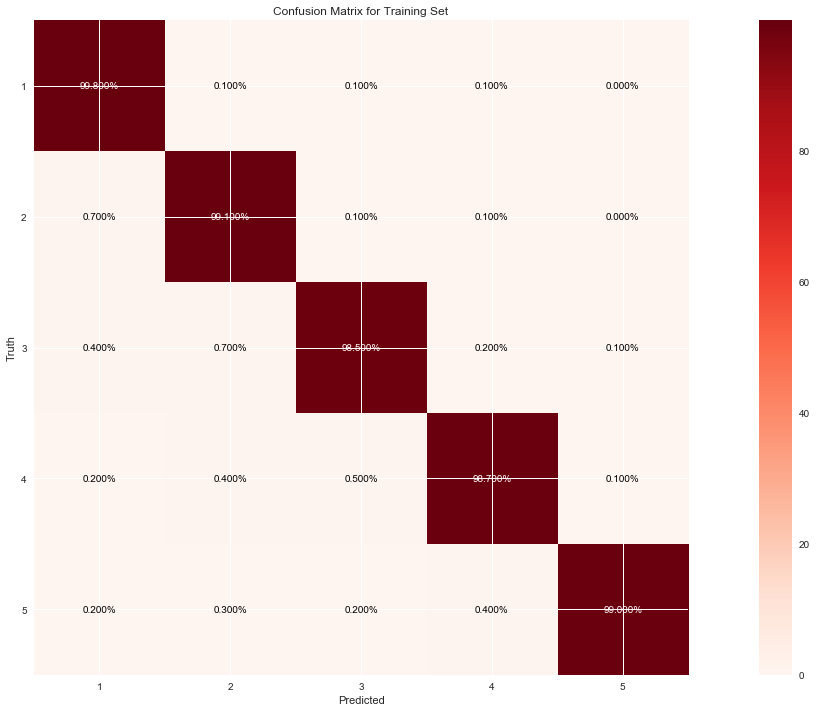

In [178]:
from sklearn.metrics import confusion_matrix

#create the confusion matrix of the training set
confusion_train = confusion_matrix(Y_train, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Training Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

In [179]:
from sklearn.model_selection import cross_val_score

cross_val_accuracy = cross_val_score(forest, X_train, Y_train, \
                               cv=3, scoring="accuracy")
cross_val_f1 = cross_val_score(forest, X_train, Y_train, \
                               cv=3, scoring="f1_micro")

cross_val_accuracy = np.mean(cross_val_accuracy)
cross_val_f1 = np.mean(cross_val_f1)

print(f"Training Set Accuracy: {cross_val_accuracy*100:.3f}%")
print(f"Training Set F1 Score: {cross_val_f1:.3f}")

Training Set Accuracy: 30.045%
Training Set F1 Score: 0.300


In [180]:
%%time
import xgboost as xgb

y_train_shifted = Y_train-1
y_test_shifted = Y_test-1

train_set = xgb.DMatrix(X_train, label=y_train_shifted)
test_set = xgb.DMatrix(X_test, label=y_test_shifted)

parameters = {"max_depth": 4, "eta": 0.2, "silent": 1, \
              "objective": "multi:softprob", "num_class": 5}

boost = xgb.train(parameters, train_set, 100)

Wall time: 14.5 s


In [181]:
y_pred = boost.predict(train_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(Y_train, y_pred)
f1_score = metrics.f1_score(Y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

Training Set Accuracy: 85.635%
Training Set F1 Score: 0.856


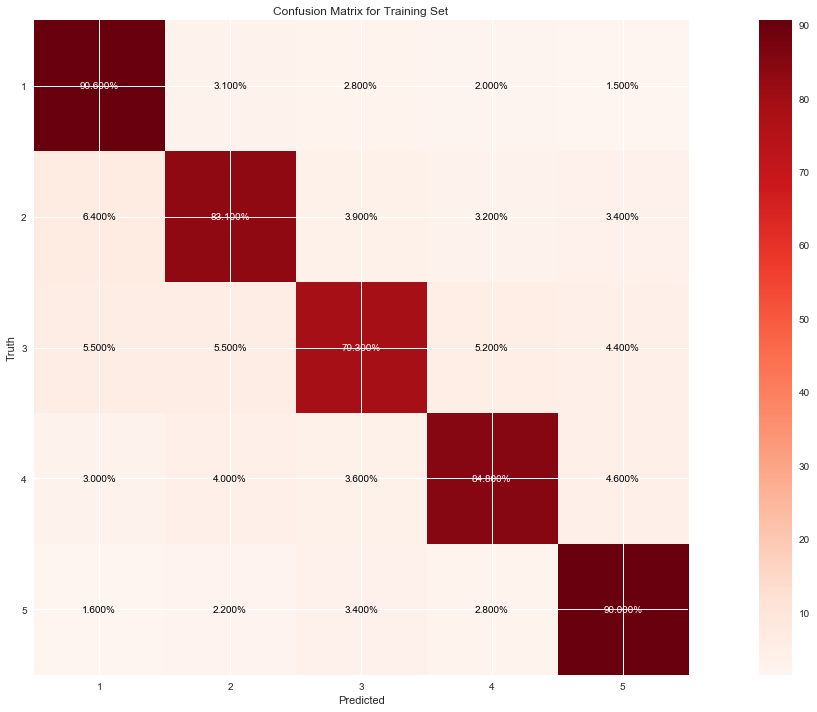

In [182]:
#create the confusion matrix of the training set
confusion_train = confusion_matrix(Y_train, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Training Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

In [183]:
%%time
boost_cv = xgb.cv(dtrain=train_set, params=parameters, nfold=3, \
                  num_boost_round=50, early_stopping_rounds=10, \
                  metrics="merror", as_pandas=True, seed=42)

display(boost_cv.head())

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.595344,0.009827,0.680013,0.008098
1,0.552285,0.003510,0.668797,0.009752
2,0.536425,0.005659,0.661922,0.011206
3,0.515619,0.003840,0.651790,0.009326
4,0.497467,0.001380,0.646483,0.010267


Wall time: 15.7 s


In [184]:
cross_val_accuracy = boost_cv.iloc[-1,2]
cross_val_accuracy = 1-cross_val_accuracy

print(f"Training Set Accuracy: {cross_val_accuracy*100:.3f}%")

Training Set Accuracy: 40.586%


In [185]:
y_pred = boost.predict(test_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(Y_test, y_pred)
f1_score = metrics.f1_score(Y_test, y_pred, average="micro")

print(f"Test Set Accuracy: {accuracy*100:.3f}%")
print(f"Test Set F1 Score: {f1_score:.3f}")

Test Set Accuracy: 40.524%
Test Set F1 Score: 0.405


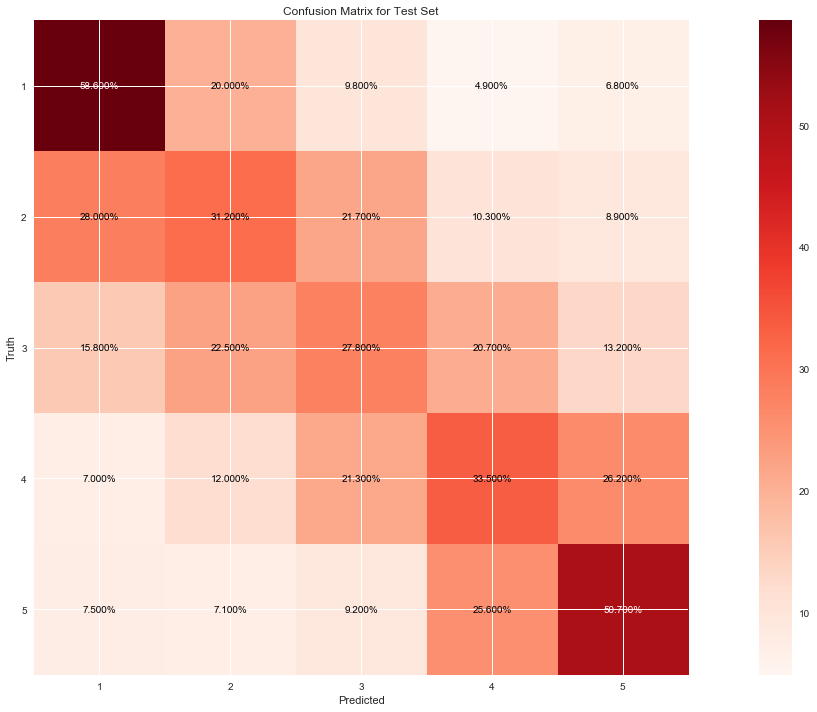

In [186]:
#create the confusion matrix of the test set
confusion_train = confusion_matrix(Y_test, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Test Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

In [187]:
X = trimmed_df.iloc[:, :-1]
y = trimmed_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)

In [188]:
y_train_shifted = y_train-1
y_test_shifted = y_test-1

train_set = xgb.DMatrix(X_train, label=y_train_shifted)
test_set = xgb.DMatrix(X_test, label=y_test_shifted)

y_pred = boost.predict(test_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred, average="micro")

print(f"Balanced Test Set Accuracy: {accuracy*100:.3f}%")
print(f"Balanced Test Set F1 Score: {f1_score:.3f}")

Balanced Test Set Accuracy: 57.209%
Balanced Test Set F1 Score: 0.572


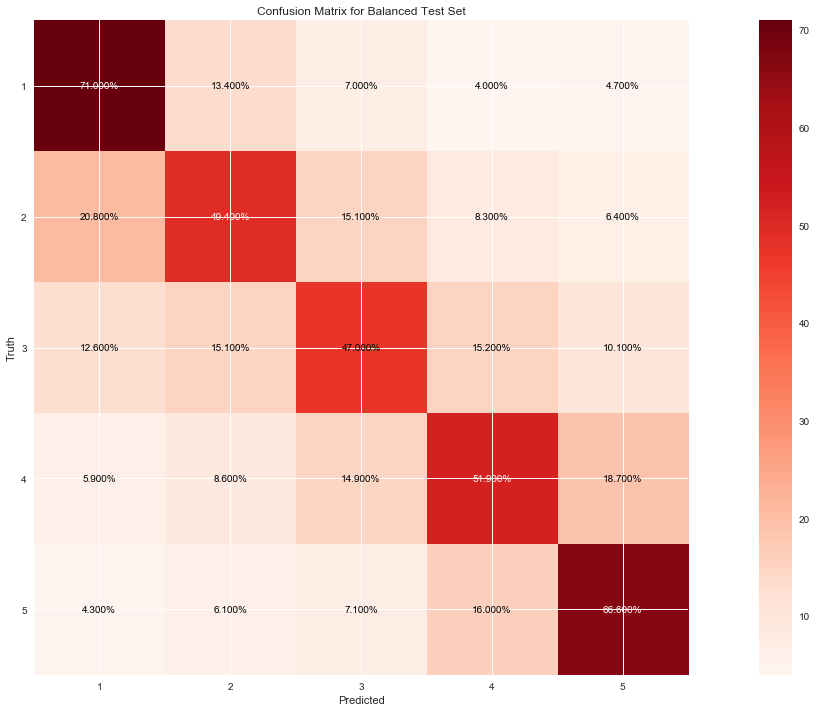

In [189]:
#create the confusion matrix of the balanced test set
confusion_train = confusion_matrix(y_test, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Balanced Test Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

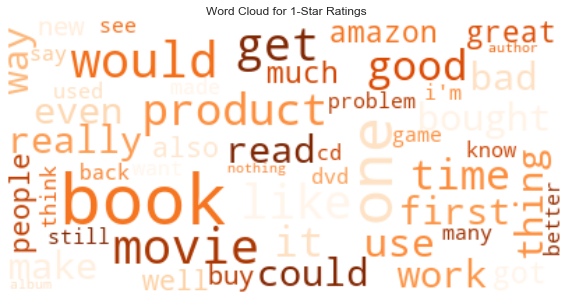

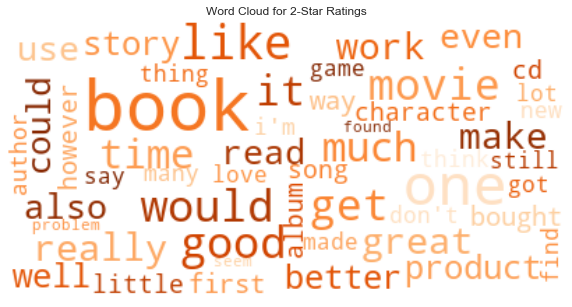

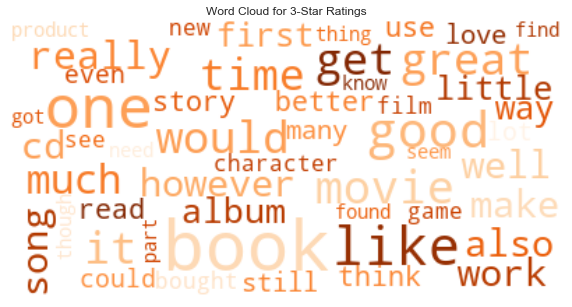

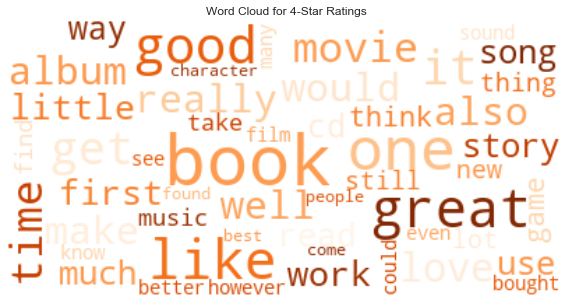

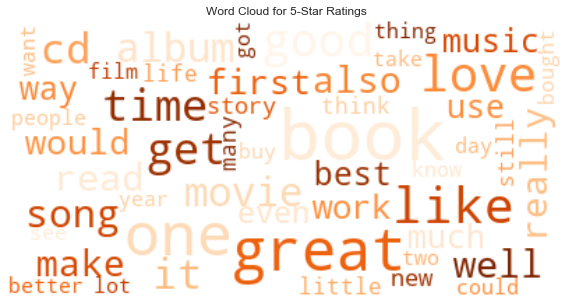

In [190]:
from wordcloud import WordCloud

wordcloud = WordCloud(stopwords = set(stop_words), min_font_size=10, \
                      max_font_size=50, max_words=50, \
                      background_color="white", colormap = "Oranges")

one_star_text = " ".join(df[df["overall"]==1]["reviewText"].values).lower()
two_star_text = " ".join(df[df["overall"]==2]["reviewText"].values).lower()
three_star_text = " ".join(df[df["overall"]==3]["reviewText"].values).lower()
four_star_text = " ".join(df[df["overall"]==4]["reviewText"].values).lower()
five_star_text = " ".join(df[df["overall"]==5]["reviewText"].values).lower()

text_list = [one_star_text, two_star_text, three_star_text, \
             four_star_text, five_star_text]

for index, text in enumerate(text_list):
    f, axes = plt.subplots(figsize=(10,7))
    wordcloud.generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for {index+1}-Star Ratings")
    plt.axis("off")
    plt.show()

In [191]:
df['overall'].unique()

array([1, 4, 3, 5, 2], dtype=int64)

In [192]:
df['overall'].value_counts()

1    4600
5    4550
4    4490
2    4481
3    4379
Name: overall, dtype: int64

# Ensemble Method

In [193]:
# Get some classifiers to evaluate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

seed = 1075
np.random.seed(seed)

X = model_df.iloc[:, :-1]
y = model_df.iloc[:, -1]

# Create classifiers
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SVC()
rg = RidgeClassifier()

clf_array = [rf, et, knn, svc, rg]

for clf in clf_array:
    vanilla_scores = cross_val_score(clf, X, y, cv=2, n_jobs=-1)
    bagging_clf = BaggingClassifier(clf, 
       max_samples=0.4, max_features=10, random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, X, y, cv=10, 
       n_jobs=-1)
    
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(clf.__class__.__name__, 
                                                              vanilla_scores.mean(), vanilla_scores.std()))
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__, 
                                                                        bagging_scores.mean(), bagging_scores.std()))

Mean of: 0.383, std: (+/-) 0.000 [RandomForestClassifier]
Mean of: 0.360, std: (+/-) 0.008 [Bagging RandomForestClassifier]

Mean of: 0.376, std: (+/-) 0.001 [ExtraTreesClassifier]
Mean of: 0.360, std: (+/-) 0.008 [Bagging ExtraTreesClassifier]

Mean of: 0.318, std: (+/-) 0.001 [KNeighborsClassifier]
Mean of: 0.313, std: (+/-) 0.012 [Bagging KNeighborsClassifier]

Mean of: 0.437, std: (+/-) 0.004 [SVC]
Mean of: 0.354, std: (+/-) 0.009 [Bagging SVC]

Mean of: 0.428, std: (+/-) 0.002 [RidgeClassifier]
Mean of: 0.337, std: (+/-) 0.007 [Bagging RidgeClassifier]



In [194]:
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier,VotingClassifier
# Set up voting
eclf = VotingClassifier(estimators=[('Random Forests', rf), ('Extra Trees', et), 
                                    ('KNeighbors', knn), ('SVC', svc), ('Ridge Classifier', rg)], voting='hard')

for clf, label in zip([rf, et, knn, svc, rg, eclf], ['Random Forest', 'Extra Trees', 
                                                     'KNeighbors', 'SVC', 'Ridge Classifier', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=2, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.386, std: (+/-) 0.001 [Random Forest]
Mean: 0.379, std: (+/-) 0.001 [Extra Trees]
Mean: 0.318, std: (+/-) 0.001 [KNeighbors]
Mean: 0.437, std: (+/-) 0.004 [SVC]
Mean: 0.428, std: (+/-) 0.002 [Ridge Classifier]
Mean: 0.425, std: (+/-) 0.002 [Ensemble]


In [195]:
# Set up ensemble voting for bagging
ebclf_array = []

for clf in clf_array:
    ebclf_array.append(BaggingClassifier(clf, max_samples=0.25, 
                                   max_features=10, random_state=seed))

v_eclf = VotingClassifier(estimators=zip(['Bagging Random Forest', 'Bagging Extra Trees', 'Bagging KNeighbors',
                                          'Bagging SVC', 'Bagging Ridge Classifier'],
                                         ebclf_array), 
                          voting='hard')

ebclf_array.append(v_eclf)

for clf, label in zip(ebclf_array, ['Bagging Random Forest', 'Bagging Extra Trees', 'Bagging KNeighbors',
                              'Bagging SVC', 'BaggingRidge Classifier']):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.359, std: (+/-) 0.008 [Bagging Random Forest]
Mean: 0.355, std: (+/-) 0.009 [Bagging Extra Trees]
Mean: 0.311, std: (+/-) 0.009 [Bagging KNeighbors]
Mean: 0.350, std: (+/-) 0.008 [Bagging SVC]
Mean: 0.338, std: (+/-) 0.008 [BaggingRidge Classifier]


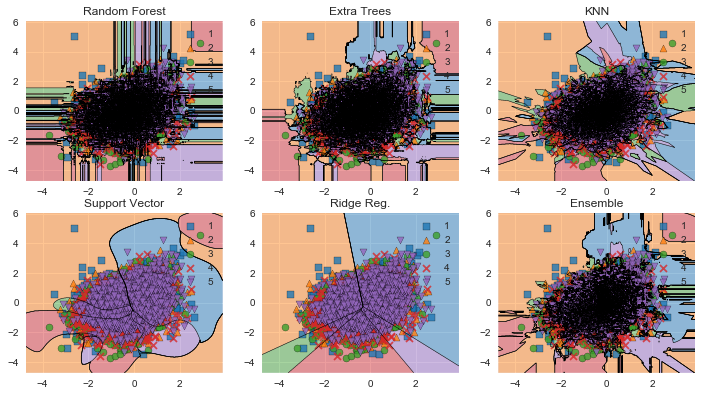

In [196]:
# Now plot the decision regions with only two features
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(12, 10))
labels = ['Random Forest', 'Extra Trees', 'KNN', 'Support Vector',
          'Ridge Reg.', 'Ensemble']

for clf, lab, grd in zip([rf, et, knn, svc, rg, eclf], 
                         labels,
                         itertools.product([0, 1, 2], repeat = 2)):

    clf.fit(X[[1,2]], y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=np.array(X[[1,2]]), 
                                y=np.array(y), clf=clf)
    plt.title(lab)

In [197]:
from mlxtend.classifier import EnsembleVoteClassifier
import warnings
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

warnings.filterwarnings('ignore')

# Create boosting classifiers
ada_boost = AdaBoostClassifier()
grad_boost = GradientBoostingClassifier()
xgb_boost = XGBClassifier()

boost_array = [ada_boost, grad_boost, xgb_boost]

eclf = EnsembleVoteClassifier(clfs=[ada_boost, grad_boost, xgb_boost], voting='hard')

labels = ['Ada Boost', 'Grad Boost', 'XG Boost', 'Ensemble']

for clf, label in zip([ada_boost, grad_boost, xgb_boost, eclf], labels):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.383, std: (+/-) 0.012 [Ada Boost]
Mean: 0.412, std: (+/-) 0.010 [Grad Boost]
Mean: 0.410, std: (+/-) 0.014 [XG Boost]
Mean: 0.415, std: (+/-) 0.012 [Ensemble]


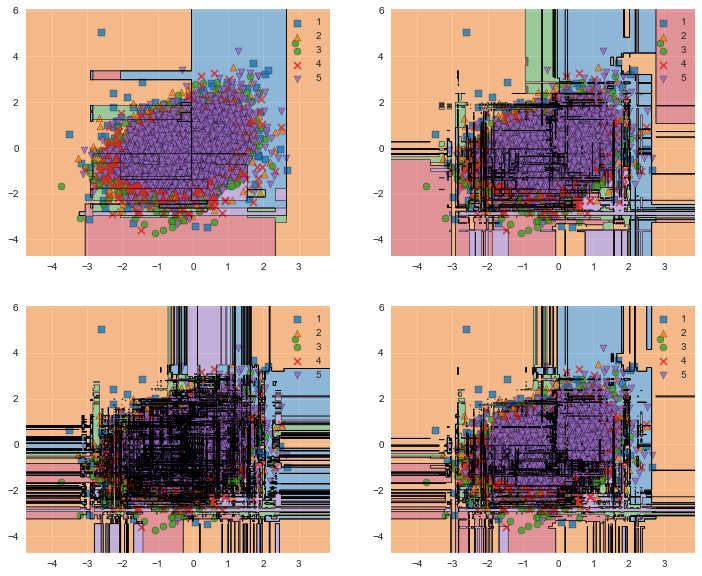

In [198]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(12, 10))

labels = ['Ada Boost', 'Grad Boost', 'XG Boost', 'Ensemble']

for clf, lab, grd in zip([ada_boost, grad_boost, xgb_boost, eclf],
                         labels,
                         itertools.product([0, 1], repeat = 2)):

    clf.fit(X[[1, 2]].values, y.values)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=np.array(X[[1, 2]].values), 
                                y=np.array(y.values), clf=clf)

In [199]:
from mlens.ensemble import SuperLearner
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

lr = LogisticRegression()

seed = 1075

ensemble = SuperLearner(scorer = accuracy_score, 
                        random_state=seed, 
                        folds=10,
                        verbose = 2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

# Build the first layer
ensemble.add([rf, et, knn, rg])
# Attach the final meta estimator
ensemble.add_meta(lr)

ensemble.fit(X_train, y_train)
preds = ensemble.predict(X_test)
print("Fit data:\n%r" % ensemble.data)
print("Accuracy score: {:.3f}".format(accuracy_score(preds, y_test)))

[MLENS] backend: threading



Fitting 2 layers
Processing layer-1             done | 00:01:23
Processing layer-2             done | 00:00:00
Fit complete                        | 00:01:24

Predicting 2 layers
Processing layer-1             done | 00:00:32
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:32
Fit data:
                                   score-m  score-s   ft-m  ft-s  pt-m  pt-s
layer-1  extratreesclassifier         0.38     0.02   5.83  0.64  0.16  0.12
layer-1  kneighborsclassifier         0.32     0.01   0.47  0.03  7.52  0.40
layer-1  randomforestclassifier       0.39     0.01  15.64  0.26  0.07  0.01
layer-1  ridgeclassifier              0.44     0.01   0.05  0.01  0.00  0.00

Accuracy score: 0.397


In [200]:
from itertools import combinations

names = ['Random Forest', 'Extra Trees', 'KNeighbors', 'SVC', 'Ridge Classifier']

def zip_stacked_classifiers(*args):
    to_zip = []
    for arg in args:
        combined_items = sum([list(map(list, combinations(arg, i))) for i in range(len(arg) + 1)], [])
        combined_items = filter(lambda x: len(x) > 0, combined_items)
        to_zip.append(combined_items)
    
    return zip(to_zip[0], to_zip[1])

stacked_clf_list = zip_stacked_classifiers(clf_array, names)

best_combination = [0.00, ""]

for clf in stacked_clf_list:
    
    ensemble = SuperLearner(scorer = accuracy_score, 
                            random_state = seed, 
                            folds = 10)
    ensemble.add(clf[0])
    ensemble.add_meta(lr)
    ensemble.fit(X_train, y_train)
    preds = ensemble.predict(X_test)
    accuracy = accuracy_score(preds, y_test)
    
    if accuracy > best_combination[0]:
        best_combination[0] = accuracy
        best_combination[1] = clf[1]
    
    print("Accuracy score: {:.3f} {}".format(accuracy, clf[1]))

print("\nBest stacking model is {} with accuracy of: {:.3f}".format(best_combination[1], best_combination[0]))

Accuracy score: 0.353 ['Random Forest']
Accuracy score: 0.352 ['Extra Trees']
Accuracy score: 0.306 ['KNeighbors']
Accuracy score: 0.384 ['SVC']
Accuracy score: 0.398 ['Ridge Classifier']
Accuracy score: 0.369 ['Random Forest', 'Extra Trees']
Accuracy score: 0.361 ['Random Forest', 'KNeighbors']
Accuracy score: 0.400 ['Random Forest', 'SVC']
Accuracy score: 0.390 ['Random Forest', 'Ridge Classifier']
Accuracy score: 0.365 ['Extra Trees', 'KNeighbors']
Accuracy score: 0.401 ['Extra Trees', 'SVC']
Accuracy score: 0.393 ['Extra Trees', 'Ridge Classifier']
Accuracy score: 0.396 ['KNeighbors', 'SVC']
Accuracy score: 0.389 ['KNeighbors', 'Ridge Classifier']
Accuracy score: 0.395 ['SVC', 'Ridge Classifier']
Accuracy score: 0.374 ['Random Forest', 'Extra Trees', 'KNeighbors']
Accuracy score: 0.402 ['Random Forest', 'Extra Trees', 'SVC']
Accuracy score: 0.393 ['Random Forest', 'Extra Trees', 'Ridge Classifier']
Accuracy score: 0.401 ['Random Forest', 'KNeighbors', 'SVC']
Accuracy score: 0.395 [